In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader, TensorDataset

Consider some target function $f:\mathbb{R}\to\mathbb{R}$, and a compact domain $D\subset \mathbb{R}$. Let $p_x$ be the uniform distribution over $D$. We then generate data $(x,y)$ such that $x\sim p_x$ and $y=f(x)$.

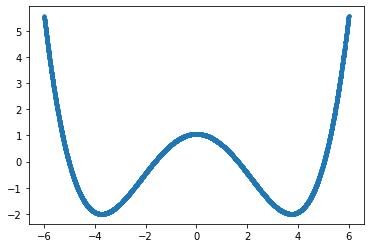

In [3]:
# hyperparameters
np.random.seed(0)
N = 10**4
low = -6
high = 6
params = [0.5, 0, -3.5, -0.5, 1, -3]

# define target function
def quadratic(x, _params):
    [a, b, c] = _params
    return (a*x+b)**2 + c

def target(x):
    [a1, b1, c1, a2, b2, c2] = params
    h = quadratic(x, [a1,b1,c1])
    return quadratic( h, [a2,b2,c2] ) + h

# training data
X = np.random.uniform(low, high, N)
Y = np.vectorize(target)(X)

# visualize
plt.scatter(X, Y, marker=".")
plt.show()

Some graphical intuitions for hyperparameters:
https://www.desmos.com/calculator/pc0szofbfh.

In [4]:
# simple test NN:
class Lambda(nn.Module):
    """
    Input: A Function
    Returns : A Module that can be used inside nn.Sequential
    """
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): 
        return self.func(x)
    
def quad_activation(x):
    return x**2

def reshape(x):
    return torch.reshape(x, (len(X), 1))

class single_layer_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(1, 1),  # x -> ax+b
            Lambda(quad_activation),  # (ax+b)^2
            nn.Linear(1, 1),  # k(ax+b)^2+c
        )
    
    def forward(self, x):
        return self.sequential(x)

In [5]:
# TRAINING
# training hyperparameters
model = single_layer_NN()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

epochs = 50
batch_size = 32

# tensorize inputs
X_tensor = torch.reshape(Tensor(X),(N,1))
y_tensor = torch.reshape(Tensor(Y),(N,1))
dataset = TensorDataset(X_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Epoch training
for t in range(epochs):
    print(f"\nEpoch: {t+1:n}")
    
    for (i, (X_batch, y_batch)) in enumerate(data_loader):
        # forward
        pred = model(X_batch.float())
        loss = loss_fn(pred, y_batch)
        
        # backward
        optimizer.zero_grad()  # clear gradient
        loss.backward()
        optimizer.step()
    
    print(f"loss={loss:.3f}")
    print("_"*50)


Epoch: 1
loss=7.397
__________________________________________________

Epoch: 2
loss=4.366
__________________________________________________

Epoch: 3
loss=5.448
__________________________________________________

Epoch: 4
loss=2.907
__________________________________________________

Epoch: 5
loss=7.734
__________________________________________________

Epoch: 6
loss=2.819
__________________________________________________

Epoch: 7
loss=2.174
__________________________________________________

Epoch: 8
loss=3.619
__________________________________________________

Epoch: 9
loss=2.790
__________________________________________________

Epoch: 10
loss=1.453
__________________________________________________

Epoch: 11
loss=4.941
__________________________________________________

Epoch: 12
loss=3.131
__________________________________________________

Epoch: 13
loss=1.381
__________________________________________________

Epoch: 14
loss=3.343
______________________________________

[-0.3874983787536621, 0.026693003252148628, 0.2981797158718109, -0.6700695157051086]


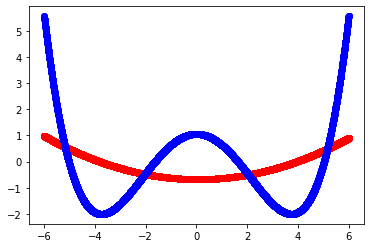

In [12]:
# first layer result
first_layer_params = []
for p in model.parameters():
    first_layer_params.append(p.item())
print(first_layer_params)

y_pred = model(X_tensor)
plt.scatter(X_tensor.detach().numpy(), y_pred.detach().numpy(), color="red")
plt.scatter(X_tensor.detach().numpy(), y_tensor.detach().numpy(), color="blue")
plt.show()

In [ ]:
second_layer = single_layer_NN()
